In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")

# Schematic illustration

In [97]:
def scfa(y, t, k, r, K, a, b, Kb):
    prod,deg,scfa = y
    dydt = [-k*prod, r*deg*(1-deg/K), a*prod-b*deg*scfa/(scfa+Kb)]
    return dydt

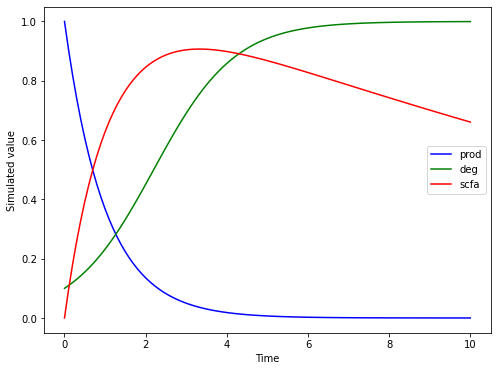

In [102]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1, ncols=1, sharex=True, sharey=True)
y0=[1,0.1,0]
t = np.linspace(0, 10, 101)
k = 1
r = 1
K = 1
a = 1
b = 0.1
Kb = 1
sol = odeint(scfa, y0, t, args=(k, r, K, a, b, Kb))
plt.plot(t, sol[:, 0], 'b', label='prod')
plt.plot(t, sol[:, 1], 'g', label='deg')
plt.plot(t, sol[:, 2], 'r', label='scfa')
plt.xlabel('Time')
plt.ylabel('Simulated value')
plt.legend()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_biphasic_fermentation.svg", format="svg")

# Plot positively and negatively associated taxa

In [4]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

A2         ASF356  Acetatifactor  Acetatifactor_dash_muris  \
SampleID                                                                 
sample131  0.0  108301.701888    7101.750943                       0.0   
sample132  0.0  405068.034693   50064.588558                       0.0   
sample133  0.0   36169.603950   45332.570284                       0.0   
sample134  0.0  484302.054587   10150.043060                       0.0   
sample135  0.0   91489.970533   42374.302141                       0.0   

           Acidovorax  Acinetobacter  \
SampleID                               
sample131         0.0            0.0   
sample132         0.0            0.0   
sample133         0.0            0.0   
sample134         0.0            0.0   
sample135         0.0            0.0   

           Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2  \
SampleID                                                       
sample131                                                0.0   
sample132                                                0.0   
sample133                                                0.0   
sample134                                                0.0   
sample135                                                0.0   

           Acutalibacter_dash_muris  Adlercreutzia_dash_mucosicola  \
SampleID                                                             
sample131                       0.0                       0.000000   
sample132                       0.0                       0.000000   
sample133                       0.0                       0.000000   
sample134                       0.0                       0.000000   
sample135                       0.0                   12519.680178   

           Adlercreutzia_dash_muris  ...  \
SampleID                             ...   
sample131                       0.0  ...   
sample132                       0.0  ...   
sample133                       0.0  ...   
sample134                       0.0  ...   
sample135                       0.0  ...   

           _leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group  \
SampleID                                                                                   
sample131                                                0.0                               
sample132                                                0.0                               
sample133                                                0.0                               
sample134                                                0.0                               
sample135                                                0.0                               

           _leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group  \
SampleID                                                                                     
sample131                                       63028.039623                                 
sample132                                       80103.341692                                 
sample133                                           0.000000                                 
sample134                                      105850.449056                                 
sample135                                           0.000000                                 

           _leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group  \
SampleID                                                                                
sample131                                                0.0                            
sample132                                                0.0                            
sample133                                                0.0                            
sample134                                                0.0                            
sample135                                                0.0                            

           _leftsquarebracket_Rumin

In [5]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_joined = pd.merge(df_rf, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','ElasticNet']
df_joined['Type'] = 'Producer'
df_joined.loc[df_joined.ElasticNet<0,'Type'] = 'Consumer'
df_joined.head()

SCFA                          Taxon  RandomForest  ElasticNet      Type
0  Acetate                 Muribaculaceae      0.042678   -0.650962  Consumer
1  Acetate   Akkermansia_dash_muciniphila      0.016252   -0.195898  Consumer
2  Acetate  Bacteroides_dash_acidifaciens      0.021612    0.133174  Producer
3  Acetate     Bacteroides_dash_uniformis      0.010127   -0.217277  Consumer
4  Acetate                 Parasutterella      0.034985   -0.091220  Consumer

In [20]:
df_joined[(df_joined.SCFA=='Propionate') & (df_joined.Type=='Consumer')].sort_values(by='RandomForest', ascending=False)

SCFA                                    Taxon  RandomForest  \
86  Propionate                              Bacteroides      0.071111   
84  Propionate                           Parasutterella      0.047326   
87  Propionate             Clostridia_dash_UCG_dash_014      0.033054   
80  Propionate                           Muribaculaceae      0.024579   
81  Propionate             Akkermansia_dash_muciniphila      0.022851   
91  Propionate                Escherichia_dash_Shigella      0.020658   
88  Propionate  Lachnospiraceae_dash_NK4A136_dash_group      0.012076   

    ElasticNet      Type  
86   -4.215720  Consumer  
84   -1.303477  Consumer  
87   -0.156686  Consumer  
80   -2.750587  Consumer  
81   -3.178660  Consumer  
91   -1.411014  Consumer  
88   -4.895412  Consumer

In [8]:
df_16S_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Beijing')]
for scfa in ['Acetate','Butyrate','Propionate']:
    df_16S_scfa_producer = deepcopy(df_16S)
    df_16S_scfa_consumer = deepcopy(df_16S)
    df_16S_scfa_producer = df_16S_scfa_producer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Producer'),'Taxon'])]
    df_16S_scfa_consumer = df_16S_scfa_consumer[list(df_joined.loc[(df_joined.SCFA==scfa)&(df_joined.Type=='Consumer'),'Taxon'])]
    for c in df_16S_scfa_producer.columns:
        df_16S_scfa_producer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    for c in df_16S_scfa_consumer.columns:
        df_16S_scfa_consumer[c] *= list(df_joined.loc[(df_joined.SCFA==scfa) & (df_joined.Taxon==c), 'RandomForest'])[0]
    df_16S_scfa_producer = df_16S_scfa_producer.sum(axis=1).to_frame()
    df_16S_scfa_producer.columns = [scfa+'_Producer']
    df_16S_scfa_consumer = df_16S_scfa_consumer.sum(axis=1).to_frame()
    df_16S_scfa_consumer.columns = [scfa+'_Consumer']
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_producer, left_index=True, right_index=True, how='inner')
    df_16S_meta = pd.merge(df_16S_meta, df_16S_scfa_consumer, left_index=True, right_index=True, how='inner')
df_16S_meta.head()

MiceID     Vendor  Day    Diet  Acetate_Producer  Acetate_Consumer  \
SampleID                                                                       
sample411    GI1  Guangdong    0  Inulin      3.139669e+05      7.031459e+05   
sample412    GI2  Guangdong    0  Inulin      1.258994e+06      1.374761e+06   
sample413    GI3  Guangdong    0  Inulin      1.607275e+06      1.864928e+06   
sample414    GI4  Guangdong    0  Inulin      7.603002e+05      1.201901e+06   
sample426    GI1  Guangdong    1  Inulin      8.410833e+06      5.630112e+06   

           Butyrate_Producer  Butyrate_Consumer  Propionate_Producer  \
SampleID                                                               
sample411       2.546082e+05       1.111449e+06         6.124732e+05   
sample412       1.129004e+06       1.994775e+06         2.608066e+06   
sample413       1.448299e+06       2.717150e+06         3.079373e+06   
sample414       5.987234e+05       1.903916e+06         1.433460e+06   
sample426       7.509836e+06       9.629146e+06         1.118939e+07   

           Propionate_Consumer  
SampleID                        
sample411         3.853810e+05  
sample412         5.270814e+05  
sample413         8.326643e+05  
sample414         5.325742e+05  
sample426         8.436014e+06

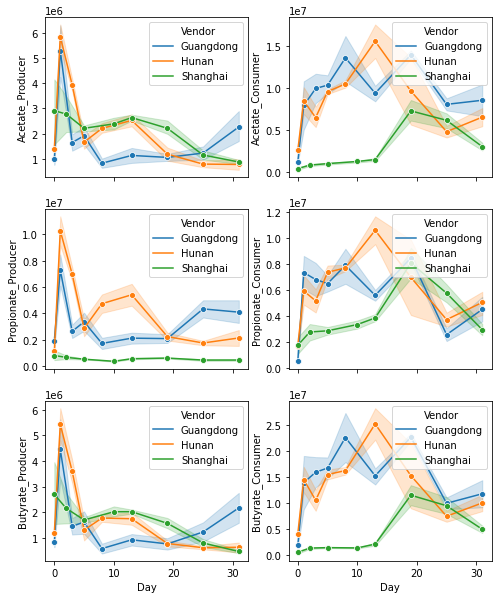

In [17]:
fig, ax = plt.subplots(figsize=(8,10), nrows=3, ncols=2, sharex=True)
for i,scfa in enumerate(['Acetate','Propionate','Butyrate']):
    for j,mtype in enumerate(['Producer','Consumer']):
        sns.lineplot(x='Day',y=scfa+'_'+mtype,hue='Vendor',marker='o',ci=68,data=df_16S_meta,ax=ax[i,j])
        #ax[i,j].set_yscale('log')
        #ax[j,i].set_ylim([2e5,5e7])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grouped_scfa_producer_consumer.svg", format="svg")

# Plot most significant SCFA producer

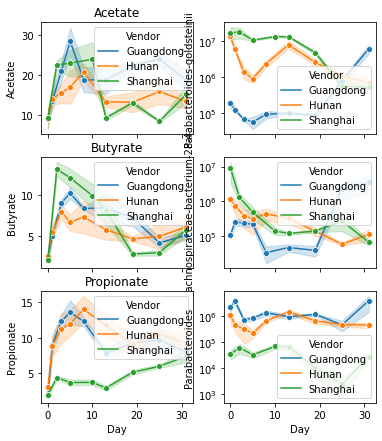

In [6]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta= pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
df_16S_meta = df_16S_meta[(df_16S_meta.Diet=='Inulin') & (df_16S_meta.Vendor!='Beijing') & (df_16S_meta.Day<=500)]
#df_16S_meta.loc[df_16S_meta.Vendor!='Shanghai','Vendor'] = 'Other'

# df_qpcr = pd.read_excel('../../../../data/qPCR.xlsx', index_col=0)
# df_qpcr_meta= pd.merge(df_meta, df_qpcr, left_index=True, right_index=True, how='inner')
# df_qpcr_meta = df_qpcr_meta[(df_qpcr_meta.Diet=='Inulin') & (df_qpcr_meta.Vendor!='Beijing')]

df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa_meta= pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[(df_scfa_meta.Diet=='Inulin') & (df_scfa_meta.Vendor!='Beijing') & (df_scfa_meta.Day<=500)]
#df_scfa_meta.loc[df_scfa_meta.Vendor!='Shanghai','Vendor'] = 'Other'

fig, ax = plt.subplots(figsize=(6,7), nrows=3, ncols=2, sharex=True)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    if scfa == 'Acetate':
        producer = 'Parabacteroides-goldsteinii'
    if scfa == 'Butyrate':
        producer = 'Lachnospiraceae-bacterium-28-4'
    if scfa == 'Propionate':
        producer = 'Parabacteroides'
    
    sns.lineplot(x='Day',y=scfa, marker='o', hue='Vendor', ci=68, data=df_scfa_meta, ax=ax[k,0])
    #sns.lineplot(x='Day',y='Value', marker='o', hue='Vendor', ci=68, data=df_qpcr_meta, ax=ax[1,k])
    sns.lineplot(x='Day',y=producer, marker='o', hue='Vendor', ci=68, data=df_16S_meta, ax=ax[k,1])
    ax[k,0].set_title(scfa)
    ax[k,1].set_yscale('log')
    ax[k,1].minorticks_off()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("topscfa_producer.svg", format="svg")

# Prediction using Beijing data

In [2]:
df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_meta = df_scfa_meta[df_scfa_meta.Diet=='Inulin']
df_scfa_meta.head()

MiceID   Vendor  Day    Diet    Acetate  Butyrate  Propionate
SampleID                                                               
sample141    BI1  Beijing    0  Inulin   5.233899  1.109582    1.930933
sample142    BI2  Beijing    0  Inulin  13.459823  1.546647    3.621771
sample143    BI3  Beijing    0  Inulin  18.075378  1.682656    2.859916
sample144    BI4  Beijing    0  Inulin  12.580368  1.477688    3.148773
sample145    BI5  Beijing    0  Inulin   8.065127  1.835172    3.134209

In [3]:
set(df_scfa_meta.Day)

{0, 1, 2, 3, 5, 8, 10, 13, 19, 25, 31}

In [4]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_X = pd.read_csv('independent_variables_top40.csv', index_col=0)
df_16S = df_16S[df_X.columns]
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_16S_meta = pd.merge(df_meta, df_16S, left_index=True, right_index=True, how='inner')
df_16S_meta = df_16S_meta[df_16S_meta.Diet=='Inulin']
df_16S_meta.head()

MiceID   Vendor  Day    Diet  Muribaculaceae  \
SampleID                                                 
sample141    BI1  Beijing    0  Inulin    2.558057e+07   
sample142    BI2  Beijing    0  Inulin    1.221770e+07   
sample143    BI3  Beijing    0  Inulin    2.765050e+07   
sample144    BI4  Beijing    0  Inulin    2.018975e+07   
sample145    BI5  Beijing    0  Inulin    4.461250e+07   

           Akkermansia_dash_muciniphila  Bacteroides_dash_acidifaciens  \
SampleID                                                                 
sample141                  2.803564e+06                   7.311172e+05   
sample142                  1.240226e+05                   1.518836e+06   
sample143                  3.721486e+05                   1.919005e+07   
sample144                  5.967865e+04                   5.359602e+06   
sample145                  6.279657e+05                   3.589337e+06   

           Bacteroides_dash_uniformis  Parasutterella  Faecalibaculum  ...  \
SampleID                                                               ...   
sample141                19913.697925    6.520314e+06    1.503484e+07  ...   
sample142                17045.760332    1.957324e+06    8.628681e+06  ...   
sample143                27876.300265    4.014187e+05    7.158634e+06  ...   
sample144                34429.992550    1.032900e+05    2.648814e+06  ...   
sample145                40405.300152    7.912705e+04    1.075791e+07  ...   

           Ruminococcaceae  Anaerotruncus  Gastranaerophilales  \
SampleID                                                         
sample141     6.415056e+05   3.442225e+05         2.474988e+05   
sample142     4.320219e+05   1.610530e+05         3.996937e+04   
sample143     6.829694e+05   9.700952e+05         2.313733e+05   
sample144     1.223412e+06   2.947207e+06         4.820199e+04   
sample145     5.909275e+05   5.825097e+05         1.188589e+06   

           Helicobacter_dash_mastomyrinus     Alistipes      Bilophila  \
SampleID                                                                 
sample141                    0.000000e+00  1.473614e+06  236119.561110   
sample142                    0.000000e+00  1.714568e+06  317403.813075   
sample143                    1.063481e+06  9.869604e+06   96173.235914   
sample144                    5.187452e+05  6.002295e+06  218056.619485   
sample145                    4.747623e+05  7.808324e+06  114481.683763   

           Lachnoclostridium  Peptococcaceae  \
SampleID                                       
sample141      371248.225601    46939.430823   
sample142      122259.246518    17633.545171   
sample143      419538.318989   131018.611246   
sample144      596786.537537   144605.968711   
sample145      331660.172078   109431.021244   

           Lachnospiraceae_dash_UCG_dash_006  Bacteroides_dash_caecimuris  
SampleID                                                                   
sample141                      516333.739054                120904.594544  
sample142                      144007.285562                114030.258771  
sample143                      288519.707743                489229.069651  
sample144                      454475.901663                172149.962751  
sample145                      254216.680120                127950.117147  

[5 rows x 44 columns]

In [5]:
df_opt_paras = pd.read_excel('optimal_rf_hyperparameters_top40.xlsx', index_col=0)
df_opt_paras.head()

SCFA  n_estimators max_features  max_depth  min_samples_split  \
0     Acetate           650         sqrt       30.0                  2   
1    Butyrate           200         sqrt       20.0                  2   
2  Propionate           200         sqrt        NaN                  5   

   min_samples_leaf  bootstrap  
0                 1       True  
1                 1       True  
2                 4       True

In [6]:
df_Y = pd.read_csv('response_variables_scfa_deriv.csv', index_col=0)
df_Y.head()

Acetate  Butyrate  Propionate
SampleID                                  
sample411 -11.331097 -1.456967    1.658890
sample412   4.127181  3.888098   13.125370
sample413  11.745672  5.345893   14.519866
sample414  14.622299  4.552023   11.448899
sample426   1.576644  1.048318    4.307852

In [7]:
df_res = None
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_Y[scfa]))
    X = np.asarray(df_X.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    print(scfa, clf.score(X, dydt))
    
    curr_X = df_16S_meta.iloc[:,4:].values
    pred_Y = regr.predict(curr_X)
    curr_df = df_16S_meta.iloc[:,[0,1,2,3]]
    curr_df['SCFA'] = scfa
    curr_df['Deriv'] = pred_Y

    if df_res is None:
        df_res = curr_df
    else:
        df_res = pd.concat([df_res, curr_df])
df_res.head()

Acetate 0.8919064620960989
Butyrate 0.9112792933919069
Propionate 0.5989366119486321


MiceID   Vendor  Day    Diet     SCFA     Deriv
SampleID                                                 
sample141    BI1  Beijing    0  Inulin  Acetate  2.472056
sample142    BI2  Beijing    0  Inulin  Acetate  2.116492
sample143    BI3  Beijing    0  Inulin  Acetate  2.860591
sample144    BI4  Beijing    0  Inulin  Acetate  4.745692
sample145    BI5  Beijing    0  Inulin  Acetate  0.947716

In [8]:
lines = []

for curr_vendor in list(set(df_res.Vendor)):
    all_mice = list(set(df_res.loc[df_res.Vendor==curr_vendor,'MiceID']))
    for curr_mice in all_mice:
        for scfa in ['Acetate','Butyrate','Propionate']:
            curr_df = df_res[(df_res.MiceID==curr_mice)&(df_res.SCFA==scfa)].sort_values(by='Day')
            cs = CubicSpline(curr_df.Day, curr_df.Deriv)
            day0_observed = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==0),scfa].values[0]
            day0_simulated = day0_observed 
            lines.append([curr_mice, curr_vendor, 0, scfa, day0_observed, day0_simulated])
            for day in np.arange(1,32):
                observed_value = df_scfa_meta.loc[(df_scfa_meta.Vendor==curr_vendor) & (df_scfa_meta.MiceID==curr_mice) & (df_scfa_meta.Day==day),scfa]
                if len(observed_value) == 0:
                    lines.append([curr_mice, curr_vendor, day, scfa, np.NaN, day0_simulated+cs.integrate(0,day)])
                else:
                    observed_value = observed_value.values[0] 
                    lines.append([curr_mice, curr_vendor, day, scfa, observed_value, day0_simulated+cs.integrate(0,day)])
df_pred = pd.DataFrame(lines, columns=['MiceID','Vendor','Day','SCFA','Observed','Predicted'])
df_pred.head()

MiceID Vendor  Day     SCFA   Observed  Predicted
0    HI1  Hunan    0  Acetate   9.126348   9.126348
1    HI1  Hunan    1  Acetate  19.085337  16.265790
2    HI1  Hunan    2  Acetate        NaN  15.033612
3    HI1  Hunan    3  Acetate   8.261241  11.851734
4    HI1  Hunan    4  Acetate        NaN  10.541511

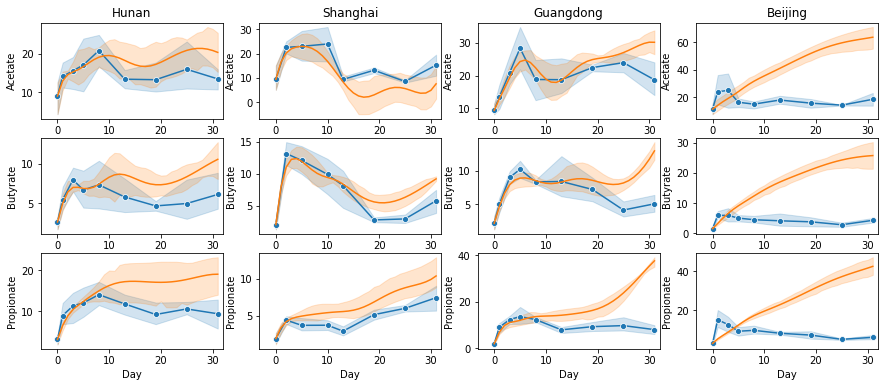

In [14]:
# plot prediction
fig, ax = plt.subplots(figsize=(15, 6), nrows=3, ncols=4)

for i,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    for j,curr_vendor in enumerate(['Hunan','Shanghai','Guangdong','Beijing']):
        curr_df = df_pred[(df_pred.Vendor==curr_vendor)&(df_pred.SCFA==scfa)]
        sns.lineplot(x='Day',y='Observed', marker='o', data=curr_df, ax=ax[i,j])
        sns.lineplot(x='Day',y='Predicted',data=curr_df, ax=ax[i,j])
        if i==0:
            ax[i,j].set_title(curr_vendor)
        ax[i,j].set_ylabel(scfa)
        ax[i,j].set_xlim([-3.2,32])